In [17]:
#search space
from hyperopt import hp

range_10 = ["auto"] +list(range(1, 10))
range_20 = list(range(1, 20))
range_20_none = [None] +list(range(1, 20))
range_300_2000 = list(range(299, 2000))
range_2_1000 = [None] + list(range(2, 1000))
range2_20 = list(range(2, 20))
range_01 = ['auto', 'sqrt', 'log2'] + [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

param_space = {
    'pca__iterated_power': hp.choice('pca__iterated_power', range_10),
    'pca__n_components': hp.choice('pca__n_components',range_20_none),
    'pca__svd_solver':hp.choice('pca__svd_solver',['auto','full','randomized']),
    'pca__tol': hp.uniform('pca__tol',0,0.5),
    'pca__whiten': hp.choice('pca__whiten', [True, False]),

    'randomforestclassifier__criterion': hp.choice('randomforestclassifier__criterion', ["gini", "entropy"]),
    'randomforestclassifier__max_depth': hp.choice('randomforestclassifier__max_depth',range_2_1000),
    'randomforestclassifier__min_samples_leaf': hp.choice('randomforestclassifier__min_samples_leaf',range_20),
    'randomforestclassifier__min_samples_split': hp.choice('randomforestclassifier__min_samples_split',range2_20),
    'randomforestclassifier__min_weight_fraction_leaf':hp.uniform('randomforestclassifier__min_weight_fraction_leaf',0.0, 0.5),
    'randomforestclassifier__max_features':hp.choice('randomforestclassifier__max_features',range_01),
    'randomforestclassifier__n_estimators': hp.choice('randomforestclassifier__n_estimators', range_300_2000),
    'randomforestclassifier__oob_score': hp.choice('randomforestclassifier__oob_score', [True, False]),
}

In [20]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from datetime import timedelta
import datetime
from hyperopt import hp,Trials,trials_from_docs

# Functions


In [3]:
def single_loss_plot_builder(trial,plot_label,xlabel,ylabel):
    losses = trial.losses()
    losses= [abs(i) for i in losses]
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 8
    plt.plot(losses, label='{}'.format(plot_label))
    plt.grid(True)
    plt.xlabel('{}'.format(xlabel))
    plt.ylabel('{}'.format(ylabel))
    plt.legend(loc=3)
    plt.show()

In [4]:
def trial_utils(trial,start,end):
    losses = trial.losses()
    losses = [abs(i) for i in losses]
    losses = np.array(losses)
    best_indices = np.argwhere(losses == np.amax(losses))
    best_indices = best_indices.flatten().tolist()
    avg_score = losses[start:end].mean()
    

    best_score_id = trial.best_trial['tid']
    best_score = abs(trial.best_trial['result']['loss'])
    
    

    print('Best score:{} \n best score id:{} \n Average score[{},{}]:{}'.format(best_score,best_score_id,start,end,avg_score))
    print("all best scores idices {}".format(best_indices))
    print("-----------")
    all_best = {}
    for t in trial.trials:
        if abs(t['result']['loss']) == best_score:
            all_best[t['tid']]= t['misc']['vals']
#     return all_best    
    

In [5]:
def find_min(losses):
    chart_list =[]
    small = losses[0]
    chart_list.append(small)
    
    for i in losses:
        if (i<small):
            chart_list.append(i)
            small = i
        else:
            chart_list.append(small)
    return chart_list





def step_step_chart(trial,start,end,plot_label,xlabel,ylabel,trial2,start2,end2,plot_label2):
    
    losses = trial.losses()
    losses = [1+i for i in losses]
    
    
    losses2 = trial2.losses()
    losses2 = [1+i for i in losses2]
    
    chart_list = find_min(losses)
    chart_list2 = find_min(losses2)
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 8
    plt.plot(chart_list[start:end], label='{}'.format(plot_label))
    plt.plot(chart_list2[start2:end2], label='{}'.format(plot_label2))
    plt.grid(True)
    plt.xlabel('{}'.format(xlabel))
    plt.ylabel('{}'.format(ylabel))
    plt.legend(loc=3)
    plt.show()

In [6]:

def time_tracker_for_each_computation(trial):
    mydata = trial.trials
    time_keeper=[]
    for i in range(len(mydata)):
        start = mydata[i]['book_time']
        end = mydata[i]['refresh_time']
        elapsedTime = end - start
        time_keeper.append(timedelta.total_seconds(elapsedTime))
    return time_keeper


def time_plot_for_each_computation(time_list,plot_label,xlabel,ylabel):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 8
    plt.plot(time_list, label='{}'.format(plot_label))
    plt.grid(True)
    plt.xlabel('{}'.format(xlabel))
    plt.ylabel('{}'.format(ylabel))
    plt.legend(loc=3)
    plt.show()
    



In [7]:

def time_tracker_plot(times,plot_label,xlabel,ylabel,show_plot=True):
    time_keeper= []

    for i in range(len(times)-1):
        if i== 0:
            time_keeper.append(0)
            
        elapsedTime = times[i+1] - times[i]
        time_keeper.append(timedelta.total_seconds(elapsedTime))
    print("total time is {}".format(np.array(time_keeper).sum()))
    print("mean time for each iteration {}".format(np.array(time_keeper).mean()))

    if show_plot:
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 20
        fig_size[1] = 8
        plt.plot(time_keeper, label='{}'.format(plot_label))
        plt.grid(True)
        plt.xlabel('{}'.format(xlabel))
        plt.ylabel('{}'.format(ylabel))
        plt.legend(loc=3)
        plt.show()

In [35]:
def find_n_initial(trial,N,good,bad):
    losses = trial.losses()
    losses_index = sorted(range(len(losses)), key=lambda k: losses[k],reverse=True)
    
    selected_list=[]
    for i,v in enumerate(losses_index):
        if i>=N:
            break
        else:
            if i < N-good:
                selected_list.append(v)
            else:
                Bests = losses_index[-good:]
                selected_list = selected_list+Bests
                break


    new_trial = []
    for i in selected_list:
        new_trial.append(trial.trials[i])

    empty_trial = Trials()
    trial_merged = trials_from_docs(list(empty_trial)+new_trial)
    
    for i,v in enumerate(trial_merged.trials):
        trial_merged.trials[i]['tid'] = int(i)
        trial_merged.trials[i]['misc']['tid'] = int(i)
        trial_merged.trials[i]['misc']['idxs']['classifier'] =[i]
        trial_merged.trials[i]['misc']['idxs']['data_preprocessing'] =[i]
        trial_merged.trials[i]['misc']['idxs']['feature_preprocessing'] =[i]
        if trial_merged.trials[i]['misc']['idxs']['pca__iterated_power']: 
            trial_merged.trials[i]['misc']['idxs']['pca__iterated_power']=[i]
            trial_merged.trials[i]['misc']['idxs']['pca__n_components']=[i]
            trial_merged.trials[i]['misc']['idxs']['pca__svd_solver']=[i]
            trial_merged.trials[i]['misc']['idxs']['pca__tol']=[i]
            trial_merged.trials[i]['misc']['idxs']['pca__whiten']=[i]
        
        if trial_merged.trials[i]['misc']['idxs']['randomforestclassifier__criterion']:
            
            trial_merged.trials[i]['misc']['idxs']['randomforestclassifier__criterion']=[i]
            trial_merged.trials[i]['misc']['idxs']['randomforestclassifier__max_depth']=[i]
            trial_merged.trials[i]['misc']['idxs']['randomforestclassifier__max_features']=[i]
            trial_merged.trials[i]['misc']['idxs']['randomforestclassifier__min_samples_leaf']=[i]
            trial_merged.trials[i]['misc']['idxs']['randomforestclassifier__min_samples_split']=[i]
            trial_merged.trials[i]['misc']['idxs']['randomforestclassifier__min_weight_fraction_leaf']=[i]
            trial_merged.trials[i]['misc']['idxs']['randomforestclassifier__n_estimators']=[i]
            trial_merged.trials[i]['misc']['idxs']['randomforestclassifier__oob_score']=[i]
    
    return trial_merged


In [ ]:
{'state': 2,
 'tid': 4985,
 'spec': None,
 'result': {'loss': -0.789, 'status': 'ok'},
 'misc': {'tid': 4985,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'KN_algorithm': [],
   'KN_n_neighbors': [],
   'alpha': [],
   'classifier': [4985],
   'data_preprocessing': [4985],
   'feature_preprocessing': [4985],
   'kernel': [],
   'loss': [],
   'max_iter': [],
   'n_components': [],
   'pca__iterated_power': [4985],
   'pca__n_components': [4985],
   'pca__svd_solver': [4985],
   'pca__tol': [4985],
   'pca__whiten': [4985],
   'penalty': [],
   'randomforestclassifier__criterion': [4985],
   'randomforestclassifier__max_depth': [4985],
   'randomforestclassifier__max_features': [4985],
   'randomforestclassifier__min_samples_leaf': [4985],
   'randomforestclassifier__min_samples_split': [4985],
   'randomforestclassifier__min_weight_fraction_leaf': [4985],
   'randomforestclassifier__n_estimators': [4985],
   'randomforestclassifier__oob_score': [4985],
   'tol': []},
  'vals': {'KN_algorithm': [],
   'KN_n_neighbors': [],
   'alpha': [],
   'classifier': [0],
   'data_preprocessing': [3],
   'feature_preprocessing': [0],
   'kernel': [],
   'loss': [],
   'max_iter': [],
   'n_components': [],
   'pca__iterated_power': [8],
   'pca__n_components': [14],
   'pca__svd_solver': [1],
   'pca__tol': [0.4569325698521843],
   'pca__whiten': [0],
   'penalty': [],
   'randomforestclassifier__criterion': [0],
   'randomforestclassifier__max_depth': [891],
   'randomforestclassifier__max_features': [0],
   'randomforestclassifier__min_samples_leaf': [2],
   'randomforestclassifier__min_samples_split': [0],
   'randomforestclassifier__min_weight_fraction_leaf': [0.00019613573721714132],
   'randomforestclassifier__n_estimators': [321],
   'randomforestclassifier__oob_score': [0],
   'tol': []}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2019, 11, 20, 0, 40, 37, 461000),
 'refresh_time': datetime.datetime(2019, 11, 20, 0, 40, 48, 785000)}

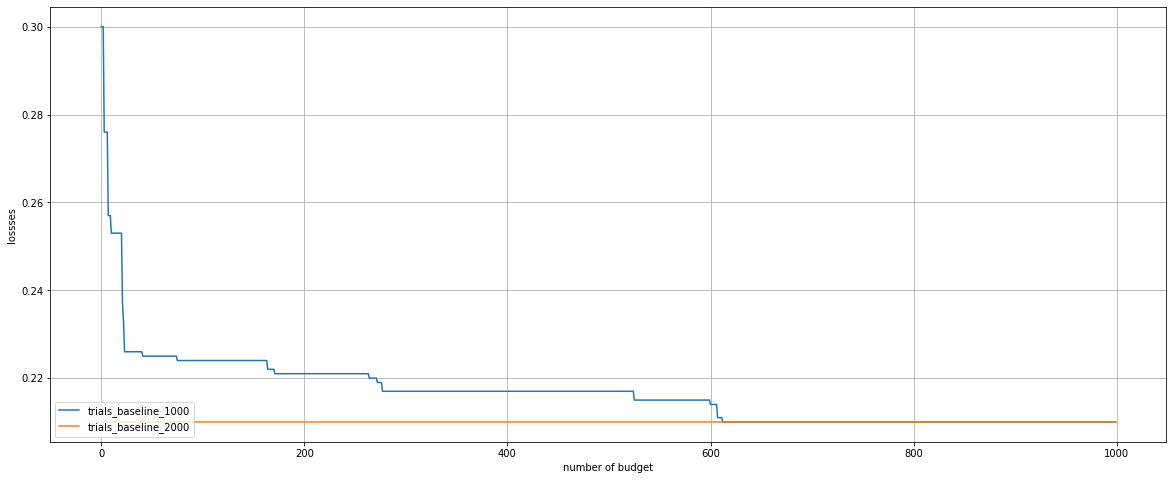

In [12]:
step_step_chart(trials_baseline_1000,0,1000,'trials_baseline_1000','number of budget','lossses',
               trials_baseline_2000,1000,2000,'trials_baseline_2000')


In [8]:
trials_baseline_1000  = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results_onserver/ashkan_server/baseline_1000_iteration.p","rb"))
trials_baseline_2000  = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results_onserver/Dima_server/baseline_2000_iteration_fixedstate.p","rb"))
trials_baseline_6000  = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results_onserver/ashkan_server/baseline_5000_iteration_with1000_initialpoint.p","rb"))

In [24]:
trials_baseline_1000_1  = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/baseline_1000run.p","rb"))
trials_baseline_1000_2  = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/baseline_1000run_2.p","rb"))

In [25]:
trial_utils(trials_baseline_1000_1,0,1000)
trial_utils(trials_baseline_1000_2,0,1000)

Best score:0.7179999999999999 
 best score id:948 
 Average score[0,1000]:0.7012859999999999
all best scores idices [948]
-----------
Best score:0.7150000000000001 
 best score id:107 
 Average score[0,1000]:0.7011629999999998
all best scores idices [107, 401, 567, 579]
-----------


In [27]:
trial_utils(trials_baseline_1000,0,1000)
trial_utils(trials_baseline_2000,1000,2000)
trial_utils(trials_baseline_6000,1000,6000)

Best score:0.79 
 best score id:611 
 Average score[0,1000]:0.729153
all best scores idices [611]
-----------
Best score:0.79 
 best score id:611 
 Average score[1000,2000]:0.744279
all best scores idices [611, 1618]
-----------
Best score:0.793 
 best score id:4891 
 Average score[1000,6000]:0.7508068000000001
all best scores idices [4891, 5842, 5851]
-----------


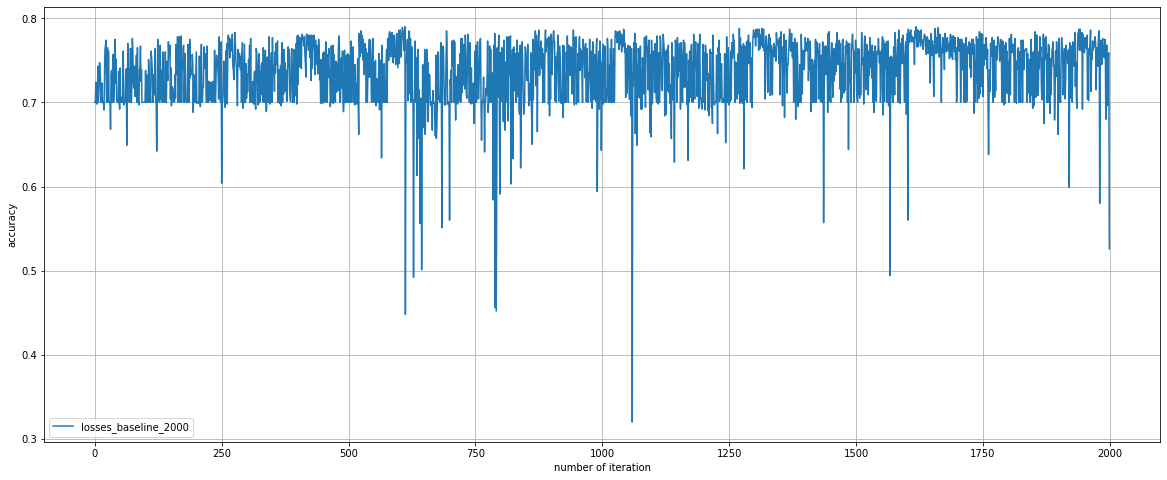

In [29]:
single_loss_plot_builder(trials_baseline_2000,'losses_baseline_2000','number of iteration','accuracy')

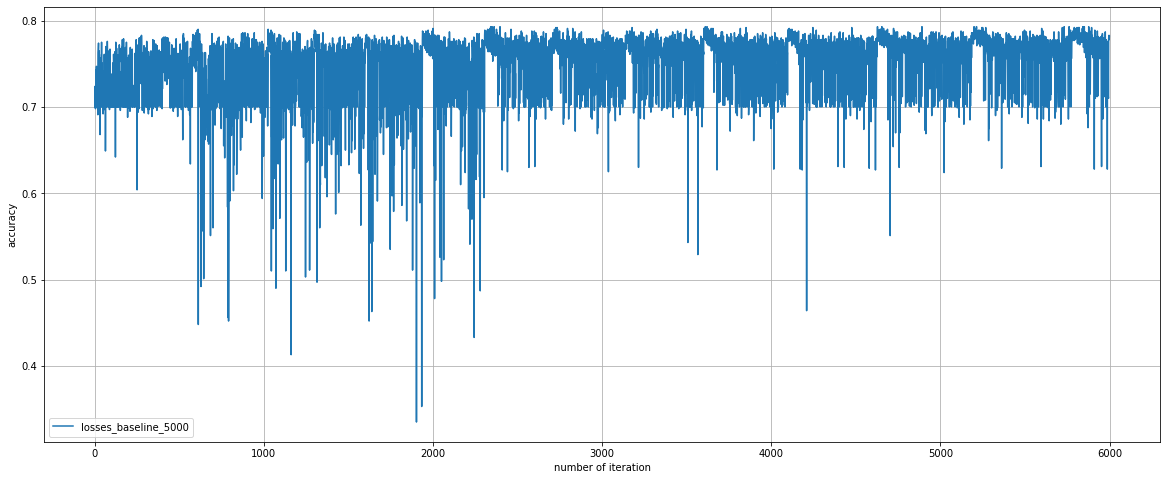

In [28]:
single_loss_plot_builder(trials_baseline_6000,'losses_baseline_5000','number of iteration','accuracy')

# Big searchspace

In [6]:
trials_bigsearchspace_1000  = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results_onserver/ashkan_server/bigsearchspace/trial_bigsearchspace_1000.p","rb"))
trials_bigsearchspace_5000  = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results_onserver/ashkan_server/bigsearchspace/trial_bigsearchspace_5000.p","rb"))

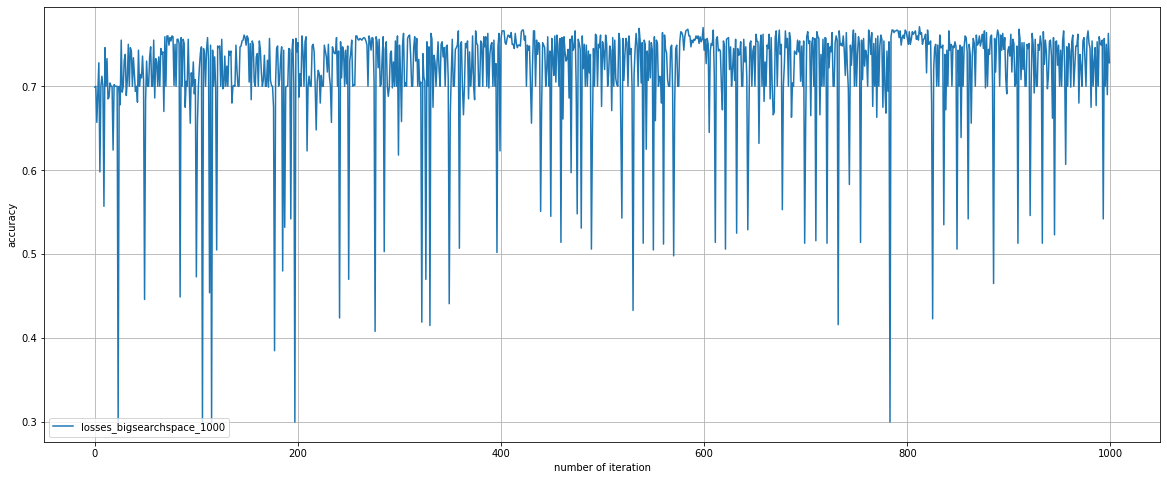

In [12]:
single_loss_plot_builder(trials_bigsearchspace_1000,'losses_bigsearchspace_1000','number of iteration','accuracy')

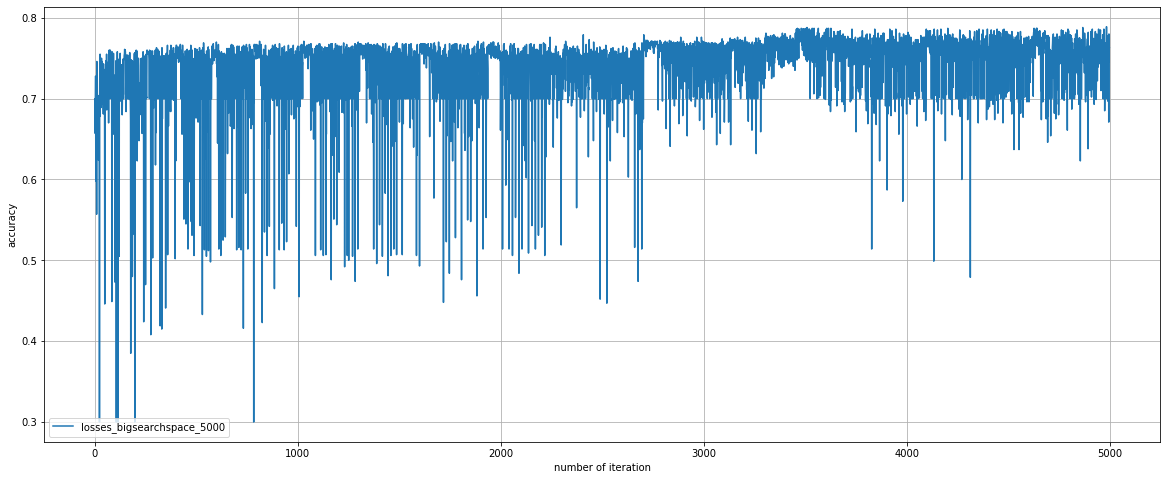

In [18]:
single_loss_plot_builder(trials_bigsearchspace_5000,'losses_bigsearchspace_5000','number of iteration','accuracy')

In [49]:
trial_utils(trials_bigsearchspace_1000,0,1000)
trial_utils(trials_bigsearchspace_5000,1000,5000)

Best score:0.771 
 best score id:812 
 Average score[0,1000]:0.7166809999999999
all best scores idices [812]
-----------
Best score:0.789 
 best score id:4985 
 Average score[1000,5000]:0.7426090000000001
all best scores idices [4985]
-----------


# time result 

# 100 iteration without inital point

In [112]:
timetracker_bigsearchspace_100_dataset31 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31.p","rb"))
trial_bigsearchspace_100_dataset31 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31,0,100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31,'time','iteration','time(sec)}',show_plot=False)

print("----------------------------")

timetracker_bigsearchspace_100_dataset31_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_2.p","rb"))
trial_bigsearchspace_100_dataset31_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_2.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_2,0,100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_2,'time','iteration','time(sec)}',show_plot=False)



Best score:0.7689999999999999 
 best score id:42 
 Average score[0,100]:0.6947699999999999
all best scores idices [42]
-----------
total time is 260.778823
mean time for each iteration 2.6077882299999997
----------------------------
Best score:0.7689999999999999 
 best score id:42 
 Average score[0,100]:0.6947699999999999
all best scores idices [42]
-----------
total time is 287.55180399999995
mean time for each iteration 2.8755180399999993


##### AVG time for each task 2.7 sec

# 100 iteration with 1000 initial points

In [17]:
timetracker_bigsearchspace_100_dataset31_1000initial = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1000initial.p","rb"))
trial_bigsearchspace_100_dataset31_1000initial = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1000initial.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_1000initial,1000,1100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_1000initial,'time','iteration','time(sec)',show_plot=False)
#0.771 acc

print("---------------------------------")
timetracker_bigsearchspace_100_dataset31_1000initial_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1000initial_2.p","rb"))
trial_bigsearchspace_100_dataset31_1000initial_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1000initial_2.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_1000initial_2,1000,1100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_1000initial_2,'time','iteration','time(sec)',show_plot=False)




Best score:0.771 
 best score id:812 
 Average score[1000,1100]:0.72531
all best scores idices [812]
-----------
total time is 72.388279
mean time for each iteration 0.72388279
---------------------------------
Best score:0.771 
 best score id:812 
 Average score[1000,1100]:0.72531
all best scores idices [812]
-----------
total time is 69.992778
mean time for each iteration 0.69992778


##### AVG time for each task 0.705 sec

# 100 iteration with 5000 initial points

In [10]:
timetracker_bigsearchspace_100_dataset31_5000initial = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_5000initial.p","rb"))
trial_bigsearchspace_100_dataset31_5000initial = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_5000initial.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_5000initial,5000,5100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_5000initial,'time','iteration','time(sec)',show_plot=False)
#~20 min
print("--------------------")
timetracker_bigsearchspace_100_dataset31_5000initial_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_5000initial_2.p","rb"))
trial_bigsearchspace_100_dataset31_5000initial_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_5000initial_2.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_5000initial_2,5000,5100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_5000initial_2,'time','iteration','time(sec)',show_plot=False)
#



Best score:0.789 
 best score id:4985 
 Average score[5000,5100]:0.7417
all best scores idices [4985]
-----------
total time is 1151.419934
mean time for each iteration 11.51419934
--------------------
Best score:0.789 
 best score id:4985 
 Average score[5000,5100]:0.7417
all best scores idices [4985]
-----------
total time is 1331.065955
mean time for each iteration 13.31065955


# 1000 iteration without initial point

Best score:0.7689999999999999 
 best score id:42 
 Average score[0,1000]:0.7060219999999999
all best scores idices [42]
-----------
total time is 1562.094938
mean time for each iteration 1.562094938


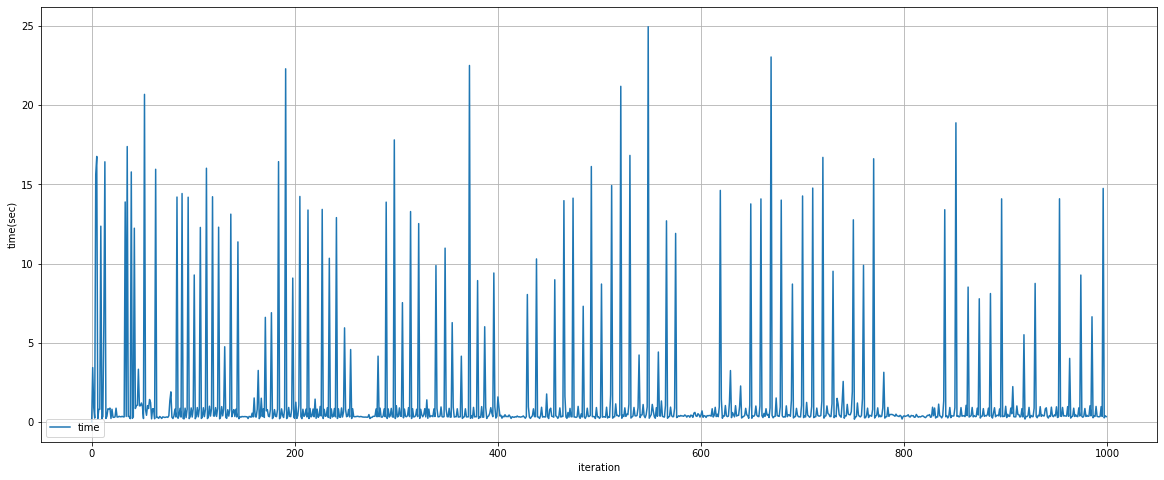

In [25]:
times2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/timetracker_bigsearchspace_1000_dataset31.p","rb"))
trial_bigsearchspace_1000_dataset31 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/trial_bigsearchspace_1000_dataset31.p","rb"))
trial_utils(trial_bigsearchspace_1000_dataset31,0,1000)
time_tracker_plot(times2,'time','iteration','time(sec)')

#~26 min 

### 1000 initiate point which is used for next experiment 

In [27]:
trial_bigsearchspace_1000 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results_onserver/ashkan_server/bigsearchspace/trial_bigsearchspace_1000.p","rb"))
trial_utils(trial_bigsearchspace_1000,0,1000)

Best score:0.771 
 best score id:812 
 Average score[0,1000]:0.7166809999999999
all best scores idices [812]
-----------


# 1000 iteration with 1000 initial points

Best score:0.772 
 best score id:1729 
 Average score[1000,2000]:0.729722
all best scores idices [1729]
-----------
total time is 800.3588750000001
mean time for each iteration 0.8003588750000001


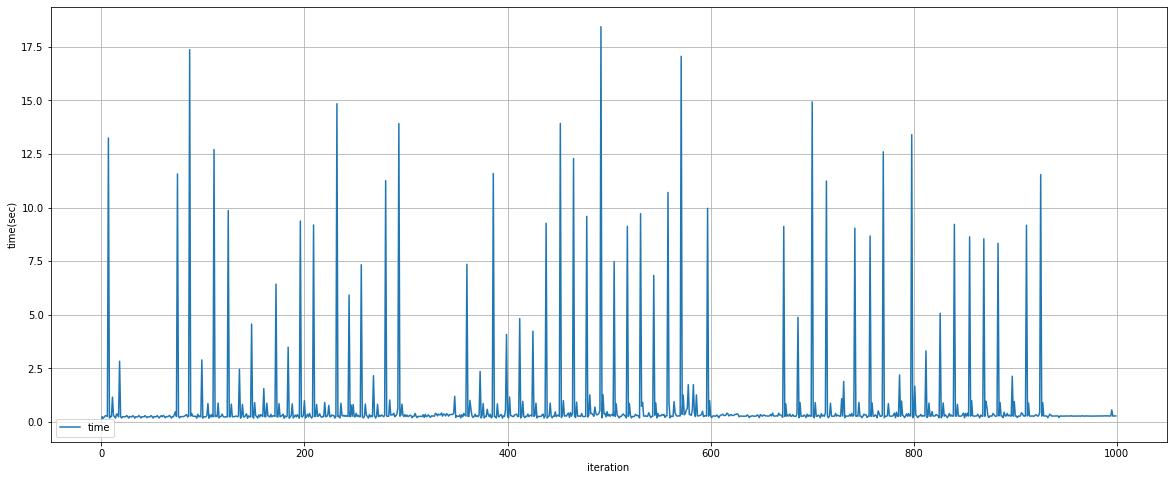

In [28]:
times3 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/timetracker_bigsearchspace_1000_dataset31_1000initial.p","rb"))
trial_bigsearchspace_1000_dataset31_1000initial = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/trial_bigsearchspace_1000_dataset31_1000initial.p","rb"))
trial_utils(trial_bigsearchspace_1000_dataset31_1000initial,1000,2000)
time_tracker_plot(times3,'time','iteration','time(sec)')
# ~14 min

# 1000 iteration with 5000 initial points

### 5000 initiate point which is used for next experiment 

In [15]:
trial_bigsearchspace_5000 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results_onserver/ashkan_server/bigsearchspace/trial_bigsearchspace_5000.p","rb"))
trial_utils(trial_bigsearchspace_5000,0,5000)

Best score:0.789 
 best score id:4985 
 Average score[0,5000]:0.7374234000000001
all best scores idices [4985]
-----------


Best score:0.789 
 best score id:4985 
 Average score[5000,6000]:0.751244
all best scores idices [4985]
-----------
total time is 12670.349919
mean time for each iteration 12.670349919


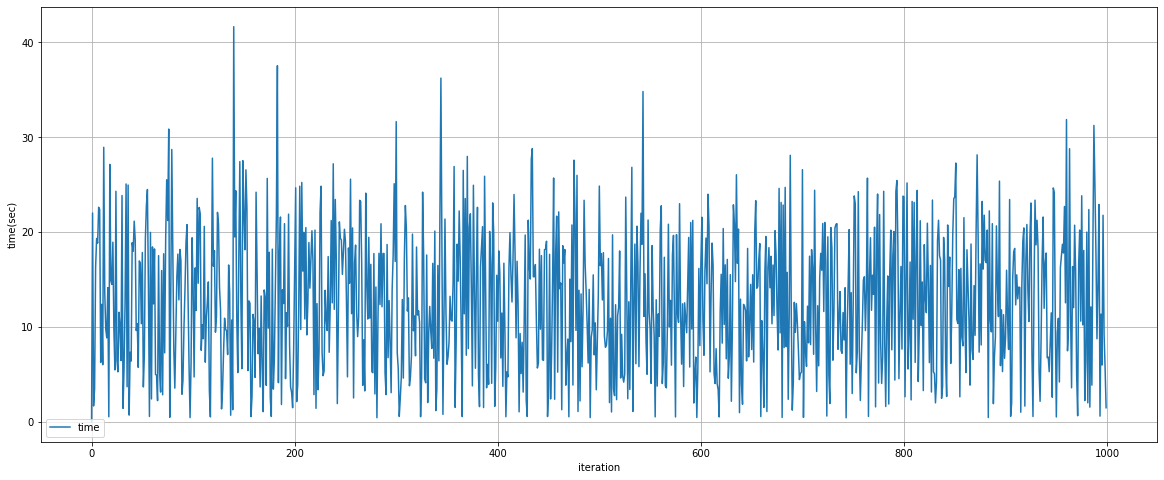

In [39]:

times4 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/timetracker_bigsearchspace_1000_dataset31_5000initial.p","rb"))
trial_bigsearchspace_1000_dataset31_5000initial = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/trial_bigsearchspace_1000_dataset31_5000initial.p","rb"))


trial_utils(trial_bigsearchspace_1000_dataset31_5000initial,5000,6000)


time_tracker_plot(times4,'time','iteration','time(sec)')
#3h 30min

## 5000 iteration with 5000 initial points 

In [13]:
# times4 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results_onserver/ashkan_server/bigsearchspace/trial_bigsearchspace_10000.p","rb"))
#we dont have timining for this experiment 
trial_bigsearchspace_5000_dataset31_5000initial = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results_onserver/ashkan_server/bigsearchspace/trial_bigsearchspace_10000.p","rb"))
trial_utils(trial_bigsearchspace_5000_dataset31_5000initial,5000,10000)


# time_tracker_plot(times4,'time','iteration','time(sec)')


Best score:0.789 
 best score id:4985 
 Average score[5000,10000]:0.7555548
all best scores idices [4985, 7750, 7831, 7866, 8739, 9109, 9252, 9253, 9258, 9259, 9269, 9273, 9280, 9289, 9293, 9306, 9316, 9326, 9328, 9338, 9352, 9357, 9366, 9380, 9406, 9409, 9422, 9434, 9465, 9474, 9494]
-----------


# Strategies for picking points out of trials

In [10]:
from hyperopt import fmin, tpe, hp, STATUS_OK,Trials,trials_from_docs
import random
from random import seed
def find_n_points(trial,number,strategy):
    """
    strategy :BEST - WORSE -RANDOM - BESTBEST
    based on  the strategy it returns N subset of provided trials
    """
    better_avg_index = []
    worse_avg_index =[]
    new_trial = []
    
    trial_loss = trial.losses()
    trial_loss = [abs(i) for i in trial_loss]
    
    avg_trial = np.array(trial_loss).mean()

    print("AVG score is {}".format(avg_trial))
    
    for x in enumerate(trial_loss):
        if x[1] > avg_trial:
            better_avg_index.append(x[0])
        else:
            worse_avg_index.append(x[0])
        
    if strategy == 'BEST':
        selected_list = better_avg_index
    if strategy == 'BESTBEST':
        selected_list = np.argsort(trial_loss)[-number:]
        
    if strategy == "WORSE":
        selected_list = worse_avg_index
    if strategy == "RANDOM":
#         seed(1)
        selected_list = random.sample(range(1, len(trial.trials)), number)
#         print(selected_list)
        
    for i in range(len(trial.trials)):
        
        if i in selected_list[0:number]:
            new_trial.append(trial.trials[i])
    empty_trial = Trials()
    trial_merged = trials_from_docs(list(empty_trial)+new_trial)
    return trial_merged

In [15]:
trial_1000_random_outof5000 = find_n_points(trial_bigsearchspace_5000,1000,'RANDOM')

pickle.dump(trial_1000_random_outof5000, open('/home/dfki/Desktop/Thesis/hyperopt/results/madeup_trials/trial_1000_random_outof5000_1.p', 'wb'))



AVG score is 0.7374234000000001


In [25]:
trial_utils(trial_25_BESTBEST_outof5000,0,25)

Best score:0.789 
 best score id:4985 
 Average score[0,25]:0.789
all best scores idices [0]
-----------


In [26]:
trial_25_BESTBEST_outof5000.trials

[{'state': 2,
  'tid': 4985,
  'spec': None,
  'result': {'loss': -0.789, 'status': 'ok'},
  'misc': {'tid': 4985,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'KN_algorithm': [],
    'KN_n_neighbors': [],
    'alpha': [],
    'classifier': [4985],
    'data_preprocessing': [4985],
    'feature_preprocessing': [4985],
    'kernel': [],
    'loss': [],
    'max_iter': [],
    'n_components': [],
    'pca__iterated_power': [4985],
    'pca__n_components': [4985],
    'pca__svd_solver': [4985],
    'pca__tol': [4985],
    'pca__whiten': [4985],
    'penalty': [],
    'randomforestclassifier__criterion': [4985],
    'randomforestclassifier__max_depth': [4985],
    'randomforestclassifier__max_features': [4985],
    'randomforestclassifier__min_samples_leaf': [4985],
    'randomforestclassifier__min_samples_split': [4985],
    'randomforestclassifier__min_weight_fraction_leaf': [4985],
    'randomforestclassifier__n_estimators': [4985],
    'randomfore

### N points better than AVG accuracy of trial

##### First run  and  Second run

In [128]:
time_tracker_100_1000initial_bestthanavg = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1000initial_bestthanavg.p","rb"))
trial_100_1000initial_bestthanavg = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1000initial_bestthanavg.p","rb"))
trial_utils(trial_100_1000initial_bestthanavg,1000,1100)
time_tracker_plot(time_tracker_100_1000initial_bestthanavg,'time','iteration','time(sec)',show_plot=False)


print("-----------------------------------")
#second run
time_tracker_100_1000initial_bestthanavg_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1000initial_bestthanavg_2.p","rb"))
trial_100_1000initial_bestthanavg_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1000initial_bestthanavg_2.p","rb"))
trial_utils(trial_100_1000initial_bestthanavg_2,1000,1100)
time_tracker_plot(time_tracker_100_1000initial_bestthanavg_2,'time','iteration','time(sec)',show_plot=False)


Best score:0.771 
 best score id:812 
 Average score[1000,1100]:0.6951800000000001
all best scores idices [436, 575]
-----------
total time is 796.1594190000001
mean time for each iteration 7.9615941900000005
-----------------------------------
Best score:0.771 
 best score id:812 
 Average score[1000,1100]:0.6951800000000001
all best scores idices [436, 575]
-----------
total time is 868.056265
mean time for each iteration 8.68056265


##### AVG time for each task 8.32 sec

###  N Random points out of trials 

In [20]:
timetracker_bigsearchspace_100_dataset31_1000initial_random = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1000initial_random_1.p.p","rb"))
trial_bigsearchspace_100_dataset31_1000initial_random = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1000initial_random_1.p.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_1000initial_random,1000,1100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_1000initial_random,'time','iteration','time(sec)',show_plot=False)

print("-----------------------------------")
timetracker_bigsearchspace_100_dataset31_1000initial_random_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1000initial_random_2.p","rb"))
trial_bigsearchspace_100_dataset31_1000initial_random_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1000initial_random_2.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_1000initial_random_2,1000,1100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_1000initial_random_2,'time','iteration','time(sec)',show_plot=False)

print("-----------------------------------")
timetracker_bigsearchspace_100_dataset31_1000initial_random_3 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1000initial_random_3.p","rb"))
trial_bigsearchspace_100_dataset31_1000initial_random_3 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1000initial_random_3.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_1000initial_random_3,1000,1100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_1000initial_random_3,'time','iteration','time(sec)',show_plot=False)


Best score:0.787 
 best score id:3535 
 Average score[1000,1100]:0.70383
all best scores idices [692]
-----------
total time is 257.988668
mean time for each iteration 2.57988668
-----------------------------------
Best score:0.788 
 best score id:4868 
 Average score[1000,1100]:0.6980399999999998
all best scores idices [969]
-----------
total time is 237.07114000000004
mean time for each iteration 2.3707114000000002
-----------------------------------
Best score:0.788 
 best score id:3509 
 Average score[1000,1100]:0.6961199999999996
all best scores idices [694]
-----------
total time is 182.438962
mean time for each iteration 1.82438962


##### AVG time for each task 2.32  sec

### N worse points than avg out of 5000 trials

In [127]:
timetracker_bigsearchspace_100_dataset31_1000initial_worse = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1000initial_worse_1.p","rb"))
trial_bigsearchspace_100_dataset31_1000initial_worse = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1000initial_worse_1.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_1000initial_worse,1000,1100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_1000initial_worse,'time','iteration','time(sec)',show_plot=False)

print("----------------------------------")
timetracker_bigsearchspace_100_dataset31_1000initial_worse_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1000initial_worse_2.p","rb"))
trial_bigsearchspace_100_dataset31_1000initial_worse_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1000initial_worse_2.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_1000initial_worse_2,1000,1100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_1000initial_worse_2,'time','iteration','time(sec)',show_plot=False)


Best score:0.7529999999999999 
 best score id:1000 
 Average score[1000,1100]:0.7250199999999997
all best scores idices [1025]
-----------
total time is 108.576717
mean time for each iteration 1.08576717
----------------------------------
Best score:0.7529999999999999 
 best score id:1000 
 Average score[1000,1100]:0.7250199999999997
all best scores idices [1025]
-----------
total time is 89.413897
mean time for each iteration 0.8941389700000001


##### AVG time for each task 0.9895  sec

### 1000 top best points out of 5000 

In [135]:
timetracker_bigsearchspace_100_dataset31_1000initial_BESTBEST = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1000initial_BESTBEST_1.p","rb"))
trial_bigsearchspace_100_dataset31_1000initial_BESTBEST = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1000initial_BESTBEST_1.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_1000initial_BESTBEST,1000,1100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_1000initial_BESTBEST,'time','iteration','time(sec)',show_plot=False)

print("------------------------------")

timetracker_bigsearchspace_100_dataset31_1000initial_BESTBEST_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1000initial_BESTBEST_2.p","rb"))
trial_bigsearchspace_100_dataset31_1000initial_BESTBEST_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1000initial_BESTBEST_2.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_1000initial_BESTBEST_2,1000,1100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_1000initial_BESTBEST_2,'time','iteration','time(sec)',show_plot=False)





Best score:0.789 
 best score id:4985 
 Average score[1000,1100]:0.7172
all best scores idices [992]
-----------
total time is 224.94766300000003
mean time for each iteration 2.24947663
------------------------------
Best score:0.789 
 best score id:4985 
 Average score[1000,1100]:0.7172
all best scores idices [992]
-----------
total time is 216.68411700000001
mean time for each iteration 2.16684117


##### AVG time for each task 2.2  sec

### 25 BEST outof 5000 trials

In [20]:
timetracker_bigsearchspace_100_dataset31_25initial_BEST = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_25Bestinitial_1.p","rb"))
trial_bigsearchspace_100_dataset31_25initial_BEST = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_25Bestinitial_1.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_25initial_BEST,25,125)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_25initial_BEST,'time','iteration','time(sec)',show_plot=False)

print("-------------------------------------")

timetracker_bigsearchspace_100_dataset31_25initial_BEST_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_25Bestinitial_2.p","rb"))
trial_bigsearchspace_100_dataset31_25initial_BEST_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_25Bestinitial_2.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_25initial_BEST_2,25,125)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_25initial_BEST_2,'time','iteration','time(sec)',show_plot=False)



Best score:0.789 
 best score id:4985 
 Average score[25,125]:0.6911799999999999
all best scores idices [24]
-----------
total time is 749.942879
mean time for each iteration 7.49942879
-------------------------------------
Best score:0.789 
 best score id:4985 
 Average score[25,125]:0.6911799999999999
all best scores idices [24]
-----------
total time is 793.734917
mean time for each iteration 7.93734917


In [31]:
timetracker_bigsearchspace_100_dataset31_1initial_BEST = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1Bestinitial_1.p","rb"))
trial_bigsearchspace_100_dataset31_1initial_BEST = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1Bestinitial_1.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_1initial_BEST,1,101)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_1initial_BEST,'time','iteration','time(sec)',show_plot=False)


Best score:0.789 
 best score id:4985 
 Average score[1,101]:0.6911400000000001
all best scores idices [0]
-----------
total time is 735.990558
mean time for each iteration 7.3599055799999995


# 1000 initila = 993 bad and 7 good 

In [9]:
timetracker_bigsearchspace_100_dataset31_1000initial_newapproach = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1000initial_newapproach.p","rb"))
trial_bigsearchspace_100_dataset31_1000initial_newapproach = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1000initial_newapproach.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_1000initial_newapproach,1000,1100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_1000initial_newapproach,'time','iteration','time(sec)',show_plot=False)


Best score:0.789 
 best score id:999 
 Average score[1000,1100]:0.72089
all best scores idices [999]
-----------
total time is 39.03329599999999
mean time for each iteration 0.39033295999999995


In [36]:
trial_1000_new = find_n_initial(trial_bigsearchspace_5000,1000,7,993)
pickle.dump(trial_1000_new, open('/home/dfki/Desktop/Thesis/hyperopt/results/madeup_trials/trial_1000_new_outof5000_1.p', 'wb'))


In [41]:
timetracker_bigsearchspace_100_dataset31_1000initial_new_1 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/timetracker_bigsearchspace_100_dataset31_1000initial_new_1.p","rb"))
trial_bigsearchspace_100_dataset31_1000initial_new_1 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results/result_bigsearchspace/trial_bigsearchspace_100_dataset31_1000initial_new_1.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset31_1000initial_new_1,1000,1100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset31_1000initial_new_1,'time','iteration','time(sec)',show_plot=False)


Best score:0.789 
 best score id:999 
 Average score[1000,1100]:0.74996
all best scores idices [999]
-----------
total time is 68.52580100000002
mean time for each iteration 0.6852580100000002


In [37]:
trial_1000_new.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.29999999999999993, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'KN_algorithm': [],
    'KN_n_neighbors': [],
    'alpha': [23],
    'classifier': [0],
    'data_preprocessing': [0],
    'feature_preprocessing': [0],
    'kernel': [],
    'loss': [23],
    'max_iter': [23],
    'n_components': [],
    'pca__iterated_power': [0],
    'pca__n_components': [0],
    'pca__svd_solver': [0],
    'pca__tol': [0],
    'pca__whiten': [0],
    'penalty': [23],
    'randomforestclassifier__criterion': [],
    'randomforestclassifier__max_depth': [],
    'randomforestclassifier__max_features': [],
    'randomforestclassifier__min_samples_leaf': [],
    'randomforestclassifier__min_samples_split': [],
    'randomforestclassifier__min_weight_fraction_leaf': [],
    'randomforestclassifier__n_estimators': [],
    'randomforestclassifier__oob_score': [],
    't

In [38]:
trial_1000_new.best_trial

{'state': 2,
 'tid': 999,
 'spec': None,
 'result': {'loss': -0.789, 'status': 'ok'},
 'misc': {'tid': 999,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'KN_algorithm': [],
   'KN_n_neighbors': [],
   'alpha': [],
   'classifier': [4985],
   'data_preprocessing': [4985],
   'feature_preprocessing': [4985],
   'kernel': [],
   'loss': [],
   'max_iter': [],
   'n_components': [],
   'pca__iterated_power': [4985],
   'pca__n_components': [4985],
   'pca__svd_solver': [4985],
   'pca__tol': [4985],
   'pca__whiten': [4985],
   'penalty': [],
   'randomforestclassifier__criterion': [4985],
   'randomforestclassifier__max_depth': [4985],
   'randomforestclassifier__max_features': [4985],
   'randomforestclassifier__min_samples_leaf': [4985],
   'randomforestclassifier__min_samples_split': [4985],
   'randomforestclassifier__min_weight_fraction_leaf': [4985],
   'randomforestclassifier__n_estimators': [4985],
   'randomforestclassifier__oob_score': [4985],

In [38]:
trial_bigsearchspace_5000.trials


[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.6990000000000001, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'KN_algorithm': [0],
    'KN_n_neighbors': [0],
    'alpha': [],
    'classifier': [0],
    'data_preprocessing': [0],
    'feature_preprocessing': [0],
    'kernel': [0],
    'loss': [],
    'max_iter': [],
    'n_components': [0],
    'pca__iterated_power': [],
    'pca__n_components': [],
    'pca__svd_solver': [],
    'pca__tol': [],
    'pca__whiten': [],
    'penalty': [],
    'randomforestclassifier__criterion': [],
    'randomforestclassifier__max_depth': [],
    'randomforestclassifier__max_features': [],
    'randomforestclassifier__min_samples_leaf': [],
    'randomforestclassifier__min_samples_split': [],
    'randomforestclassifier__min_weight_fraction_leaf': [],
    'randomforestclassifier__n_estimators': [],
    'randomforestclassifier__oob_score': [],
    'tol': []},


hi


In [33]:
trial_1000_new.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.29999999999999993, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'KN_algorithm': [],
    'KN_n_neighbors': [],
    'alpha': [23],
    'classifier': [23],
    'data_preprocessing': [23],
    'feature_preprocessing': [23],
    'kernel': [],
    'loss': [23],
    'max_iter': [23],
    'n_components': [],
    'pca__iterated_power': [23],
    'pca__n_components': [23],
    'pca__svd_solver': [23],
    'pca__tol': [23],
    'pca__whiten': [23],
    'penalty': [23],
    'randomforestclassifier__criterion': [],
    'randomforestclassifier__max_depth': [],
    'randomforestclassifier__max_features': [],
    'randomforestclassifier__min_samples_leaf': [],
    'randomforestclassifier__min_samples_split': [],
    'randomforestclassifier__min_weight_fraction_leaf': [],
    'randomforestclassifier__n_estimators': [],
    'randomforestclassifier__oob_score': []

# DATASET 32

## 100 iteration without initial point

In [9]:
timetracker_bigsearchspace_100_dataset32 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results_onserver/ashkan_server/dataset32/timetracker_bigsearchspace_100_dataset32.p","rb"))
trial_bigsearchspace_100_dataset32 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results_onserver/ashkan_server/dataset32/trial_bigsearchspace_100_dataset32.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset32,0,100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset32,'time','iteration','time(sec)',show_plot=False)

print("-------------------------------------")
timetracker_bigsearchspace_100_dataset32_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results_onserver/ashkan_server/dataset32/timetracker_bigsearchspace_100_dataset32_2.p","rb"))
trial_bigsearchspace_100_dataset32_2 = pickle.load(open("/home/dfki/Desktop/Thesis/hyperopt/results_onserver/ashkan_server/dataset32/trial_bigsearchspace_100_dataset32_2.p","rb"))
trial_utils(trial_bigsearchspace_100_dataset32_2,0,100)
time_tracker_plot(timetracker_bigsearchspace_100_dataset32_2,'time','iteration','time(sec)',show_plot=False)


Best score:0.9939958640086027 
 best score id:81 
 Average score[0,100]:0.8571647398461413
all best scores idices [81, 82, 84, 85, 87, 90, 91, 93]
-----------
total time is 14369.906997
mean time for each iteration 143.69906997
-------------------------------------
Best score:0.9939958640086027 
 best score id:81 
 Average score[0,100]:0.8571647398461413
all best scores idices [81, 82, 84, 85, 87, 90, 91, 93]
-----------
total time is 14347.124301
mean time for each iteration 143.47124301


In [137]:
#1000 iteration whithout initial point is running on ashkan server